**Pre-reading material:**

Basic Neural Network:
1. https://towardsdatascience.com/https-medium-com-piotr-skalski92-deep-dive-into-deep-networks-math-17660bc376ba
1. https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
1. https://medium.com/binaryandmore/beginners-guide-to-deriving-and-implementing-backpropagation-e3c1a5a1e536

Convolution Neural Networks:
1. https://en.m.wikipedia.org/wiki/Kernel_(image_processing)
1. https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
1. https://medium.com/@apiltamang/a-gentle-dive-into-the-anatomy-of-a-convolution-layer-6f1024339aca
1. https://end-to-end-machine-learning.teachable.com/courses/how-deep-neural-networks-work/lectures/9533964
1. https://becominghuman.ai/back-propagation-in-convolutional-neural-networks-intuition-and-code-714ef1c38199?gi=c57702fc955d
1. https://datascience.stackexchange.com/questions/55545/in-cnn-why-do-we-increase-the-number-of-filters-in-deeper-convolution-layers-fo

Cat/Dog recognition project:
1. https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/



**Step 1 - Download assets**

Lets start off by downloading all the images of cats/dogs to train and test against:


In [0]:
%%bash
cd /content/
mkdir -p assets
cd assets

pip install kaggle

export KAGGLE_USERNAME=mcheng89
export KAGGLE_KEY=e07daa138b7a622bf837cc1e1c17aa7f

# download dogs/cats assets
# NOTE: MAKE SURE TO ACCEPT RULES FIRST
# https://www.kaggle.com/c/dogs-vs-cats/rules

if [ ! -e "test1.zip" ]; then
  kaggle competitions download -c dogs-vs-cats
else
  echo kaggle contents already downloaded
fi

100%|##########| 86.8k/86.8k [00:00<00:00, 85.2MB/s]
100%|##########| 271M/271M [00:02<00:00, 99.0MB/s]
100%|##########| 543M/543M [00:04<00:00, 123MB/s]


In [0]:
%%bash
ls -l assets/
cd assets/

if [ ! -d "test1" ]; then
  unzip -q test1.zip
fi
if [ ! -d "train" ]; then
  unzip -q train.zip
fi

echo test1: `ls -1 test1 | wc -l`
echo train: `ls -1 train | wc -l`


total 833956
-rw-r--r-- 1 root root     88903 Nov 15 23:55 sampleSubmission.csv
-rw-r--r-- 1 root root 284321224 Nov 15 23:55 test1.zip
-rw-r--r-- 1 root root 569546721 Nov 15 23:55 train.zip
test1: 12500
train: 25000


**Step 2 - Preprocessing**

Keras requires different classes to be in their own subfolders. Preprocessing to arrange files into corresponding folders:

In [0]:
from os import makedirs
from os import listdir
from shutil import copyfile
from shutil import rmtree
from random import seed
from random import random

# create directories
dataset_home = 'assets/dataset/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
  # create label subdirectories
  labeldirs = ['dogs/', 'cats/']
  for labldir in labeldirs:
    newdir = dataset_home + subdir + labldir
    rmtree(newdir, ignore_errors=True)
    makedirs(newdir, exist_ok=True)

# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25

# copy training dataset images into subdirectories
src_directory = 'assets/train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		copyfile(src, dst)


In [0]:
%%bash
cd assets/dataset/

echo Image count:

echo test/cats: `ls -1 test/cats | wc -l` images
echo test/dogs: `ls -1 test/dogs | wc -l` images

echo train/cats: `ls -1 train/cats | wc -l` images
echo train/dogs: `ls -1 train/dogs | wc -l` images


Image count:
test/cats: 3175 images
test/dogs: 3128 images
train/cats: 9325 images
train/dogs: 9372 images


**Step 3 - Setup work**

Base code to execute the model:

In [0]:
from IPython.display import Image
from matplotlib import pyplot
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# plot diagnostic learning curves
def summarize_diagnostics(history, model_name):
  # plot loss
  pyplot.subplot(211)
  pyplot.title('Cross Entropy Loss')
  pyplot.plot(history.history['loss'], color='blue', label='train')
  pyplot.plot(history.history['val_loss'], color='orange', label='test')
  # plot accuracy
  pyplot.subplot(212)
  pyplot.title('Classification Accuracy')
  pyplot.plot(history.history['acc'], color='blue', label='train')
  pyplot.plot(history.history['val_acc'], color='orange', label='test')
  # save plot to file
  pyplot.savefig(model_name + '_plot.png')
  pyplot.close()

# run the model!
def run_model(model, epochs, model_name):
  # create data generator - rescale numbers to be from 0-1 (rgb = 0-255)
  train_datagen = ImageDataGenerator(rescale=1.0/255.0)
  test_datagen = ImageDataGenerator(rescale=1.0/255.0)
  # prepare iterators
  train_it = train_datagen.flow_from_directory('assets/dataset/train/',
    class_mode='binary', batch_size=64, target_size=(200, 200))
  test_it = test_datagen.flow_from_directory('assets/dataset/test/',
    class_mode='binary', batch_size=64, target_size=(200, 200))
  # fit model
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=epochs, verbose=1)
  model.save(model_name + '.h5')
  # evaluate model
  _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
  print('> %.3f' % (acc * 100.0))
  return history

Now we actually define the model here:

In [0]:
# define cnn model
def define_model1():
	model = Sequential()
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model


**Step 4 - Attempt #1**

Lets trigger the model run:

In [0]:
from keras.models import load_model

# define model
model = define_model1()
# resume from existing model
#model = load_model('model.h5')

history = run_model(model, 20, 'model1')
# draw learning curves
summarize_diagnostics(history, 'model1')

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/20
293/293 [==============================] - 78s 266ms/step - loss: 0.6980 - acc: 0.5508 - val_loss: 0.6600 - val_acc: 0.6011
Epoch 2/20
293/293 [==============================] - 75s 256ms/step - loss: 0.6533 - acc: 0.6087 - val_loss: 0.6302 - val_acc: 0.6307
Epoch 3/20
293/293 [==============================] - 75s 257ms/step - loss: 0.6271 - acc: 0.6354 - val_loss: 0.6111 - val_acc: 0.6548
Epoch 4/20
293/293 [==============================] - 75s 257ms/step - loss: 0.6104 - acc: 0.6570 - val_loss: 0.5947 - val_acc: 0.6756
Epoch 5/20
293/293 [==============================] - 75s 258ms/step - loss: 0.5893 - acc: 0.6799 - val_loss: 0.5774 - val_acc: 0.6917
Epoch 6/20
293/293 [==============================] - 76s 258ms/step - loss: 0.5675 - acc: 0.6979 - val_loss: 0.6081 - val_acc: 0.6508
Epoch 7/20
293/293 [==============================] - 75s 257ms/step - loss: 0.5352 - acc: 0.7293 - val_l

In [0]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 320000)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               40960128  
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 40,961,153
Trainable params: 40,961,153
Non-trainable params: 0
_________________________________________________________________


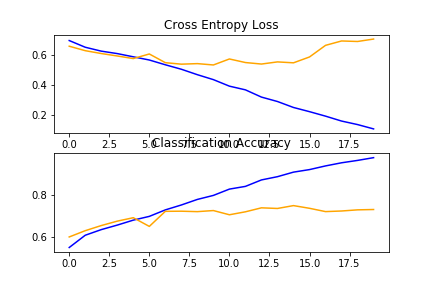

In [0]:
#display plot
Image('model1_plot.png')

**Step 5 - Attempt #2**

We got accuracy of 73%, but what if we add more convolutions (more parameters that we can learn):

In [0]:
# define cnn model
def define_model2():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model


In [0]:
model = define_model2()

history = run_model(model, 20, 'model2')
# draw learning curves
summarize_diagnostics(history, 'model2')

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/20
293/293 [==============================] - 82s 279ms/step - loss: 0.7073 - acc: 0.5930 - val_loss: 0.6536 - val_acc: 0.5818
Epoch 2/20
293/293 [==============================] - 78s 265ms/step - loss: 0.5990 - acc: 0.6746 - val_loss: 0.5781 - val_acc: 0.6951
Epoch 3/20
293/293 [==============================] - 78s 265ms/step - loss: 0.5476 - acc: 0.7214 - val_loss: 0.5368 - val_acc: 0.7293
Epoch 4/20
293/293 [==============================] - 78s 266ms/step - loss: 0.5027 - acc: 0.7561 - val_loss: 0.5070 - val_acc: 0.7561
Epoch 5/20
293/293 [==============================] - 78s 265ms/step - loss: 0.4677 - acc: 0.7775 - val_loss: 0.5436 - val_acc: 0.7230
Epoch 6/20
293/293 [==============================] - 77s 263ms/step - loss: 0.4243 - acc: 0.8056 - val_loss: 0.4764 - val_acc: 0.7695
Epoch 7/20
293/293 [==============================] - 77s 264ms/step - loss: 0.3893 - acc: 0.8266 - val_l

In [0]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
flatten_6 (Flatten)          (None, 320000)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)              

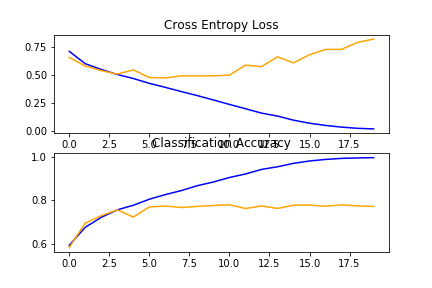

In [0]:
#display plot
Image('model2_plot.png')

**Step 6 - Attempt #3**

Now 77% accuracy. What if we add more training data. We can generate more training data by slightly modifying images from the training set.

Shifting images by few pixels or flipping images does not change the classification of a cat or a dog, but allows the model to generalize better.

In [0]:
# run the model!
def run_model_generate(model, epochs, model_name):
  # =================================================================
  # create data generator - rescale numbers to be from 0-1 (rgb = 0-255)
  # =================================================================
  train_datagen = ImageDataGenerator(rescale=1.0/255.0,
    width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # =================================================================
  test_datagen = ImageDataGenerator(rescale=1.0/255.0)
  # prepare iterators
  train_it = train_datagen.flow_from_directory('assets/dataset/train/',
    class_mode='binary', batch_size=64, target_size=(200, 200))
  test_it = test_datagen.flow_from_directory('assets/dataset/test/',
    class_mode='binary', batch_size=64, target_size=(200, 200))
  # fit model
  history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=epochs, verbose=1)
  model.save(model_name + '.h5')
  # evaluate model
  _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
  print('> %.3f' % (acc * 100.0))
  return history

In [0]:
model = define_model2()

history = run_model_generate(model, 20, 'model3')
# draw learning curves
summarize_diagnostics(history, 'model3')


Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/20
293/293 [==============================] - 231s 790ms/step - loss: 0.6891 - acc: 0.5545 - val_loss: 0.6455 - val_acc: 0.6410
Epoch 2/20
293/293 [==============================] - 221s 754ms/step - loss: 0.6462 - acc: 0.6174 - val_loss: 0.6173 - val_acc: 0.6414
Epoch 3/20
293/293 [==============================] - 223s 760ms/step - loss: 0.6156 - acc: 0.6587 - val_loss: 0.5708 - val_acc: 0.7079
Epoch 4/20
293/293 [==============================] - 223s 761ms/step - loss: 0.5892 - acc: 0.6880 - val_loss: 0.5819 - val_acc: 0.6824
Epoch 5/20
293/293 [==============================] - 223s 760ms/step - loss: 0.5733 - acc: 0.7019 - val_loss: 0.5272 - val_acc: 0.7398
Epoch 6/20
293/293 [==============================] - 223s 762ms/step - loss: 0.5584 - acc: 0.7123 - val_loss: 0.5648 - val_acc: 0.6919
Epoch 7/20
293/293 [==============================] - 224s 766ms/step - loss: 0.5429 - acc: 0.7251 

In [0]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
flatten_11 (Flatten)         (None, 320000)            0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)             

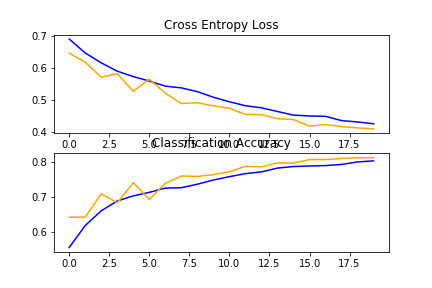

In [0]:
#display plot
Image('model3_plot.png')

**Step 7 - Attempt #4**

Now we are at an accuracy of 81.152%! Let's use a technique called "transfer learning"! Instead of creating a model from scratch, what if we used a pretrained model? How does this work though? VGG16 is a sample model that we can use; that has been trained against ImageNet dataset. The fully connected layers of a neural network takes patterns extracted from previous layers to define classes. Usually this is not specific to a single class but more for extracting well known features.

We can utilize these trained models to better extract features that help us determine if it is a cat/dog. Let us see how the VGG16 model looks:

In [0]:
from keras.applications.vgg16 import VGG16

model = VGG16(include_top=False, input_shape=(224, 224, 3))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Notice how this model looks very similar to our previous models, except that it has many more layers. It uses the same Conv2D and MaxPooling2D that we use previously.

Now let us add a fully connected layer and train on our cat/dog dataset:

In [0]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

# define cnn model
def define_model3():
  # load model
  model = VGG16(include_top=False, input_shape=(200, 200, 3))
  # mark loaded layers as not trainable
  for layer in model.layers:
    layer.trainable = False
  # add new classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output = Dense(1, activation='sigmoid')(class1)
  # define new model
  model = Model(inputs=model.inputs, outputs=output)
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [0]:
model = define_model3()

history = run_model_generate(model, 20, 'model4')
# draw learning curves
summarize_diagnostics(history, 'model4')

58892288/58889256 [==============================] - 3s 0us/step








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


Epoch 1/20
293/293 [==============================] - 204s 696ms/step - loss: 0.3536 - acc: 0.8381 - val_loss: 0.2856 - val_acc: 0.8745
Epoch 2/20
293/293 [==============================] - 191s 652ms/step - loss: 0.2425 - acc: 0.8987 - val_loss: 0.2056 - val_acc: 0.9123
Epoch 3/20
293/293 [==============================] - 192s 657ms/step - loss: 0.2407 - acc: 0.8948 - val_loss: 0.2051 - val_acc: 0.9158
Epoch 4/20
293/293 [==============================] - 191s 651ms/step - loss: 0.2162 - acc: 0.9097 - val_loss: 0.1920 - val_acc: 0.9197
Epoch 5/20
293/293 [==============================] - 190s 649ms/step - loss: 0.2057 - acc: 0.9120 - val_loss: 0.2134 - val_acc: 0.9115
Epoch 6/20
293/293 [==============================] - 185s 630ms/s

We get a much better accuracy now of 92.9%!

In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0   

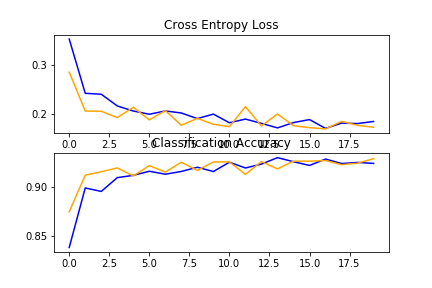

In [0]:
Image('model4_plot.png')

fin...